# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

C:\anaconda\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\anaconda\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\anaconda\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\anaconda\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [15]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [4]:
print(COCO_MODEL_PATH)
print(MODEL_DIR)

c:\python_workspace\src\Mask_RCNN\mask_rcnn_coco.h5
c:\python_workspace\src\Mask_RCNN\logs


In [16]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [17]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (511, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


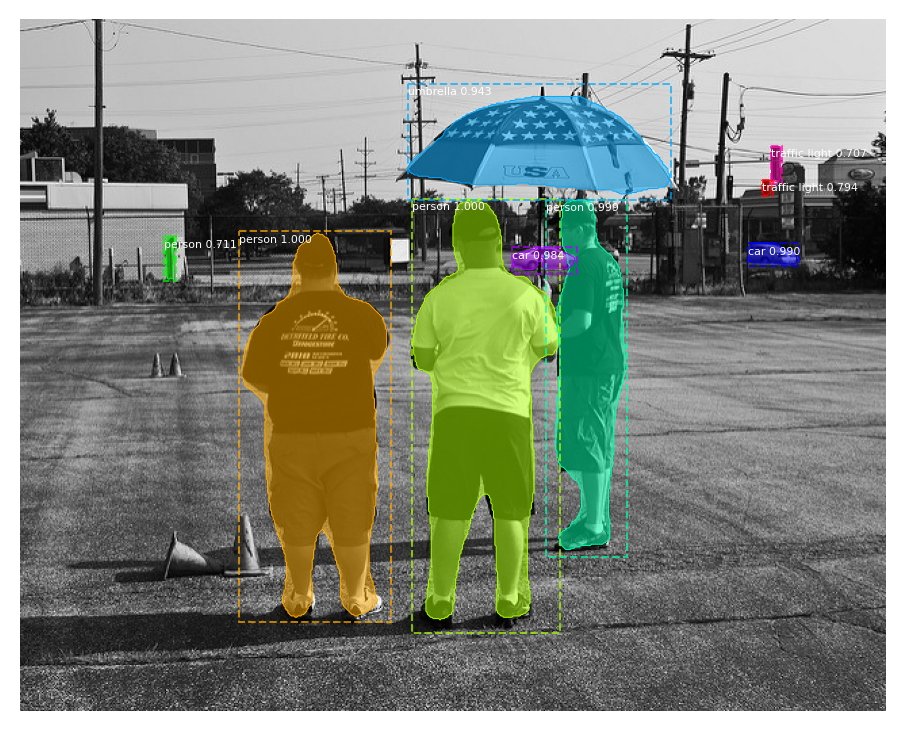

In [18]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [19]:
mask = r['masks']
mask = mask.astype(int)
num_obj = len(mask[0][0])
print(num_obj)

9


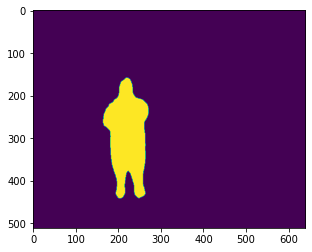

In [20]:
plt.imshow(mask[:,:,0])

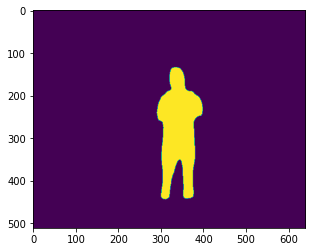

In [21]:
plt.imshow(mask[:,:,1])

In [35]:
img = mask[:,:,1]
img = img.astype(np.uint8)

name = "C:\python_workspace\src\Mask_RCNN\\videos\masks\\"+"test.jpg"

plt.imsave(name,img)

# Video detection

In [4]:
CLASS_NAMES_MASKRCNN = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                 'bus', 'train', 'truck', 'boat', 'traffic light',
                 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                 'teddy bear', 'hair drier', 'toothbrush']

# Utility functions

In [ ]:
VIDEO_DIR = "C:\python_workspace\src\Mask_RCNN\\videos"
VIDEO_SAVE_DIR = "C:\python_workspace\src\Mask_RCNN\\videos\save"
MASK_SAVE_DIR = "C:\python_workspace\src\Mask_RCNN\\videos\masks"

In [5]:
def get_color_dict():
  all_colors = visualize.random_colors(100)
  color_dict = {}
  i = 0
  for c in CLASS_NAMES_MASKRCNN:
    if not c in color_dict:
      color_dict[c] = all_colors[i]
      i = i+1
  color_dict["background"] = (0,0,0)
  return color_dict

COLOR_MAP = get_color_dict()

In [48]:
def label_to_color_image(labels):
  # Adds color defined by the dataset colormap to the label.
  h,w = labels.shape
  img = np.zeros([h,w,3])
  img = np.zeros((h,w),dtype=(float,3))
  for i in range(h):
    for j in range(w):
      img[i][j] = np.array(COLOR_MAP[CLASS_NAMES_MASKRCNN[labels[i][j]]])        
  img = img*255
  return img.astype(np.uint8)

def combine_masks(img, result):
  boxes = result['rois']
  masks = result['masks']
  class_ids = result['class_ids']
  
  N = boxes.shape[0]
  h,w,c = img.shape
  seg_map = np.zeros((h,w))
  for i in range(N):
    mask = masks[:, :, i]
    mask = mask.astype(np.uint8)
    seg_map = seg_map + mask*class_ids[i]
  
  return seg_map.astype(np.uint8)

def merge_images(foreground, background, alpha=0.3):
  out_img = np.zeros(background.shape,dtype=background.dtype)
  out_img[:,:,:] = (alpha * background[:,:,:]) + ((1-alpha) * foreground[:,:,:])
  return out_img

def get_masked_image(image, result):
  """
  Applies masks from the results to the given image
  
  """
  boxes = result['rois']
  masks = result['masks']
  
  N = boxes.shape[0]
  if not N:
    print("\n*** No instances to display *** \n")

  colors = visualize.random_colors(N)
  masked_image = image.astype(np.uint32).copy()

  for i in range(N):
      color = colors[i]

      # Mask
      mask = masks[:, :, i]
      masked_image = visualize.apply_mask(masked_image, mask, color)
  return masked_image.astype(np.uint8)

def print_fps(video):
  # Find OpenCV version
  (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

  if int(major_ver)  < 3 :
      fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
      print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
  else :
      fps = video.get(cv2.CAP_PROP_FPS)
      print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))


def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid
  
# save masks of single object to MASK_SAVE_DIR
def save_masks(masks,frameName):
  num_obj = len(masks[0][0])
  for i in range(num_obj):
    name = MASK_SAVE_DIR + "\\%d-%d.jpg"%(frameName,i)
    print(name)
    plt.imsave(name,masks[:,:,i])
  

In [42]:
print(mask.shape)

(1280, 720, 19)


In [50]:
save_masks(mask,frameName=1)

C:\python_workspace\src\Mask_RCNN\videos\masks\1-0.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-1.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-2.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-3.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-4.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-5.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-6.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-7.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-8.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-9.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-10.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-11.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-12.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-13.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-14.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-15.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-16.jpg
C:\python_workspace\src\Mask_RCNN\videos\masks\1-17.jpg
C:

In [37]:
import cv2

# number of images to be processed at once
batch_size = 3

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = batch_size

config = InferenceConfig()
config.display()

model_video = modellib.MaskRCNN(
    mode="inference", model_dir=MODEL_DIR, config=config
)
model_video.load_weights(COCO_MODEL_PATH, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, "test.mp4"))
print(os.path.join(VIDEO_DIR, "test.mp4"))

C:\python_workspace\src\Mask_RCNN\videos\test.mp4


In [39]:
frames = []
frame_count = 0
while True:
    ret, frame = video.read()
    if not ret:
        break

    frame_count += 1
    frames.append(frame)
    print('frame_count :{0}'.format(frame_count))
    if len(frames) == batch_size:
        results = model_video.detect(frames, verbose=0)
        print('Predicted')
        for i, item in enumerate(zip(frames, results)):
            frame = item[0]
            r = item[1]
            mask = r['masks']
            mask = mask.astype(int)
            #seg_map = combine_masks(frame, r)
            #seg_image = label_to_color_image(seg_map)
            #frame = merge_images(seg_image, frame)
            frameName = frame_count + i - batch_size
            save_masks(mask,frameName)
            frame = get_masked_image(frame, r)
            name = '{0}.jpg'.format(frameName)
            name = os.path.join(VIDEO_SAVE_DIR, name)
        # Clear the frames array to start the next batch
        frames = []
        
video.release()

frame_count :1
frame_count :2
frame_count :3
Predicted


TypeError: save_masks() missing 1 required positional argument: 'frameName'

In [ ]:
import glob
import os

images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "final.mp4")
make_video(outvid, images, fps=20)